Usando mnist como dataset
Encontrados 6 pares de modelos.

🧩 Cargando modelos para configuración: 128_lat_2_mnist.keras

✅ Modelo '128_lat_2_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist.keras
✅ Modelo '128_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist_beta_10.keras
✅ Modelo '128_lat_64_mnist_beta_10.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_128_mnist.keras
✅ Modelo '256_lat_128_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_64_mnist.keras
✅ Modelo '256_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 512_lat_256_mnist.keras
✅ Modelo '512_lat_256_mnist.keras' procesado.


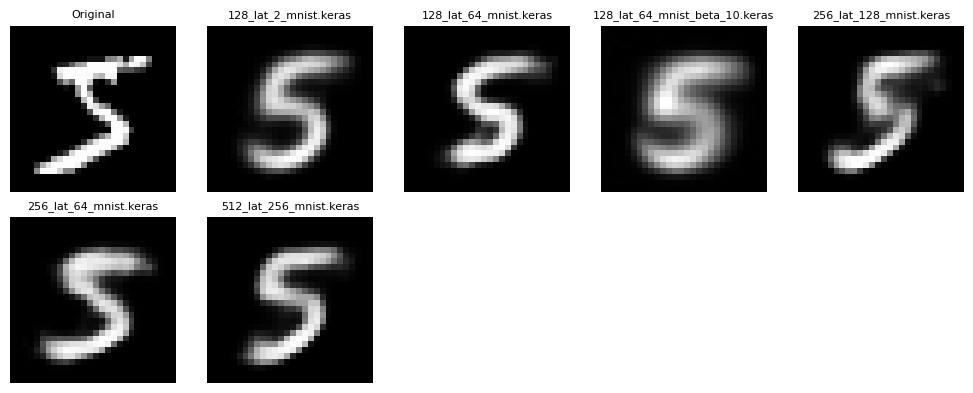

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from custom_layers.Sampling import Sampling

# Cargar datos
x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data()

# Rutas a los modelos
ENCODER_DIR = "../../modelos_entrenados/encoders/"
DECODER_DIR = "../../modelos_entrenados/decoders/"
ORIGINAL_DIM = 28 * 28

# Obtener listas de archivos
encoder_files = sorted(os.listdir(ENCODER_DIR))
decoder_files = sorted(os.listdir(DECODER_DIR))


# Función para extraer clave
def get_key(filename):
    return "_".join(filename.split("_")[2:])  # ej: 'lat_2_mnist.keras'


# Crear diccionarios clave → path
encoders = {
    get_key(f): os.path.join(ENCODER_DIR, f)
    for f in encoder_files
    if f.endswith(".keras")
}
decoders = {
    get_key(f): os.path.join(DECODER_DIR, f)
    for f in decoder_files
    if f.endswith(".keras")
}

# Claves comunes entre encoder y decoder
common_keys = sorted(set(encoders.keys()) & set(decoders.keys()))
print(f"Encontrados {len(common_keys)} pares de modelos.")

# Imagen original
x_input = x_train[:1]  # Imagen original
cond_input = y_train[:1]  # Condición
original_image = x_input[0].reshape(28, 28)

# Guardar imágenes reconstruidas + nombres
reconstructed_images = [original_image]
model_names = ["Original"]

# Iterar sobre modelos
for key in common_keys:
    print(f"\n🧩 Cargando modelos para configuración: {key}")

    encoder_path = encoders[key]
    decoder_path = decoders[key]

    encoder = load_model(encoder_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path)

    cvae = CVAE(encoder, decoder, original_dim=ORIGINAL_DIM)
    cvae.compile(optimizer="adam")

    # Codificar y decodificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input], verbose=0)
    reconstructed = cvae.decoder.predict([z, cond_input], verbose=0)

    # Guardar imagen
    reconstructed_images.append(reconstructed[0].reshape(28, 28))
    model_names.append(key)

    print(f"✅ Modelo '{key}' procesado.")

# Mostrar todas las imágenes en una sola figura
num_images = len(reconstructed_images)
cols = min(5, num_images)
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i, (img, name) in enumerate(zip(reconstructed_images, model_names)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from inferencias.inferencia import separar_digitos


x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data(dataset="fashion")



encoder = load_model("../../modelos_entrenados/encoders_fashion/en_int_256_lat_128_fashion.keras",
    custom_objects={"Sampling": Sampling}
)

decoder = load_model("../../modelos_entrenados/decoders_fashion/de_int_256_lat_128_fashion.keras")

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model("../../modelos_entrenados/predictores/CCE_Conv2D_fashion.keras",{"ReshapeLayer": ReshapeLayer})



def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 1)
    slope = trial.suggest_float("slope", 10.0, 30.0)
    
    print(f"Probando bias={bias}, slope={slope}")

    try:
        bpsnr_mean, _, _ = separar_digitos(
            x_train[:100], x_train_1[:100],
            y_train[:100], y_train_1[:100],
            cvae, predictor,
            bias=bias, slope=slope, Iterations=3
        )
        print(f"Resultado OK: bpsnr_mean = {bpsnr_mean[0]}")
        return bpsnr_mean[0]
    
    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")


Usando fashion como dataset


In [12]:
import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Probamos 30 combinaciones

# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)




[I 2025-08-05 19:40:58,252] A new study created in memory with name: no-name-a22db94a-905d-4fb3-aa31-bb6a8c80bc59


Probando bias=0.998187461912193, slope=27.194107865807126
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:00,348] Trial 0 finished with value: 8.409048080444336 and parameters: {'bias': 0.998187461912193, 'slope': 27.194107865807126}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 8.409048080444336
Probando bias=0.9532062033509502, slope=16.884414320062163
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:02,127] Trial 1 finished with value: 9.949880599975586 and parameters: {'bias': 0.9532062033509502, 'slope': 16.884414320062163}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.949880599975586
Probando bias=0.27330962809207765, slope=19.64567436779189
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:03,836] Trial 2 finished with value: 14.965746879577637 and parameters: {'bias': 0.27330962809207765, 'slope': 19.64567436779189}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 14.965746879577637
Probando bias=0.398413995784734, slope=12.953426422028224
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:05,563] Trial 3 finished with value: 14.70499038696289 and parameters: {'bias': 0.398413995784734, 'slope': 12.953426422028224}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 14.70499038696289
Probando bias=0.3828289452155035, slope=19.249856626000472
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:07,291] Trial 4 finished with value: 14.470101356506348 and parameters: {'bias': 0.3828289452155035, 'slope': 19.249856626000472}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 14.470101356506348
Probando bias=0.4563457581793291, slope=16.012449077941522
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:09,031] Trial 5 finished with value: 14.016702651977539 and parameters: {'bias': 0.4563457581793291, 'slope': 16.012449077941522}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 14.016702651977539
Probando bias=0.6657046732600174, slope=14.428642169271606
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:10,776] Trial 6 finished with value: 12.183597564697266 and parameters: {'bias': 0.6657046732600174, 'slope': 14.428642169271606}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 12.183597564697266
Probando bias=0.8754978590313448, slope=22.122317324970336
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:12,495] Trial 7 finished with value: 10.268148422241211 and parameters: {'bias': 0.8754978590313448, 'slope': 22.122317324970336}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.268148422241211
Probando bias=0.10345975738986352, slope=27.846331884671688
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:14,204] Trial 8 finished with value: 14.367805480957031 and parameters: {'bias': 0.10345975738986352, 'slope': 27.846331884671688}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 14.367805480957031
Probando bias=0.8899777308511245, slope=16.91771641828839
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:15,973] Trial 9 finished with value: 10.501976013183594 and parameters: {'bias': 0.8899777308511245, 'slope': 16.91771641828839}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.501976013183594
Probando bias=0.7440316527177873, slope=29.52810217531476
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-08-05 19:41:17,734] Trial 10 finished with value: 11.150140762329102 and parameters: {'bias': 0.7440316527177873, 'slope': 29.52810217531476}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 11.150140762329102
Probando bias=0.9710636941003495, slope=23.920439278865995
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:19,416] Trial 11 finished with value: 9.080406188964844 and parameters: {'bias': 0.9710636941003495, 'slope': 23.920439278865995}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.080406188964844
Probando bias=0.9993803802818925, slope=25.219647099212136
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:21,106] Trial 12 finished with value: 8.495678901672363 and parameters: {'bias': 0.9993803802818925, 'slope': 25.219647099212136}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 8.495678901672363
Probando bias=0.7244953842643269, slope=25.53443094226731
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:22,885] Trial 13 finished with value: 11.309112548828125 and parameters: {'bias': 0.7244953842643269, 'slope': 25.53443094226731}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 11.309112548828125
Probando bias=0.7971724165008184, slope=26.12401469532472
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:24,603] Trial 14 finished with value: 10.767149925231934 and parameters: {'bias': 0.7971724165008184, 'slope': 26.12401469532472}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.767149925231934
Probando bias=0.5852356723295381, slope=24.33695712913901
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:26,324] Trial 15 finished with value: 12.340354919433594 and parameters: {'bias': 0.5852356723295381, 'slope': 24.33695712913901}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 12.340354919433594
Probando bias=0.9797002459073739, slope=10.402891241737533
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:28,076] Trial 16 finished with value: 10.426569938659668 and parameters: {'bias': 0.9797002459073739, 'slope': 10.402891241737533}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.426569938659668
Probando bias=0.8163766349106834, slope=29.752539433662214
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:29,809] Trial 17 finished with value: 10.586835861206055 and parameters: {'bias': 0.8163766349106834, 'slope': 29.752539433662214}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.586835861206055
Probando bias=0.5559251309989595, slope=21.786112663805362
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-08-05 19:41:31,741] Trial 18 finished with value: 12.78342056274414 and parameters: {'bias': 0.5559251309989595, 'slope': 21.786112663805362}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 12.78342056274414
Probando bias=0.6572006747942674, slope=27.1559873963215
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:33,479] Trial 19 finished with value: 11.641156196594238 and parameters: {'bias': 0.6572006747942674, 'slope': 27.1559873963215}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 11.641156196594238
Probando bias=0.9110401536309597, slope=22.524213183348415
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:35,220] Trial 20 finished with value: 9.975377082824707 and parameters: {'bias': 0.9110401536309597, 'slope': 22.524213183348415}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.975377082824707
Probando bias=0.977680345103536, slope=24.08975292935357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:37,038] Trial 21 finished with value: 8.942558288574219 and parameters: {'bias': 0.977680345103536, 'slope': 24.08975292935357}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 8.942558288574219
Probando bias=0.9877460404905072, slope=27.82477262400745
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:38,791] Trial 22 finished with value: 8.534908294677734 and parameters: {'bias': 0.9877460404905072, 'slope': 27.82477262400745}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 8.534908294677734
Probando bias=0.8387960043720262, slope=28.298653584412094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:40,537] Trial 23 finished with value: 10.400708198547363 and parameters: {'bias': 0.8387960043720262, 'slope': 28.298653584412094}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.400708198547363
Probando bias=0.9913769247449508, slope=26.028601210706324
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:42,292] Trial 24 finished with value: 8.5734224319458 and parameters: {'bias': 0.9913769247449508, 'slope': 26.028601210706324}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 8.5734224319458
Probando bias=0.8883808071430614, slope=28.103022304658687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:44,062] Trial 25 finished with value: 9.923077583312988 and parameters: {'bias': 0.8883808071430614, 'slope': 28.103022304658687}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.923077583312988
Probando bias=0.7624550223647983, slope=29.955092720300286
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2025-08-05 19:41:45,786] Trial 26 finished with value: 10.986756324768066 and parameters: {'bias': 0.7624550223647983, 'slope': 29.955092720300286}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.986756324768066
Probando bias=0.9208888524585273, slope=26.469649942890513
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:47,499] Trial 27 finished with value: 9.651634216308594 and parameters: {'bias': 0.9208888524585273, 'slope': 26.469649942890513}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.651634216308594
Probando bias=0.8408115299707698, slope=24.43348827547035
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-08-05 19:41:49,276] Trial 28 finished with value: 10.45625114440918 and parameters: {'bias': 0.8408115299707698, 'slope': 24.43348827547035}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 10.45625114440918
Probando bias=0.9280293669027392, slope=20.960613018374282
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-08-05 19:41:51,018] Trial 29 finished with value: 9.934139251708984 and parameters: {'bias': 0.9280293669027392, 'slope': 20.960613018374282}. Best is trial 0 with value: 8.409048080444336.


Resultado OK: bpsnr_mean = 9.934139251708984

📊 Mejores hiperparámetros encontrados:
{'bias': 0.998187461912193, 'slope': 27.194107865807126}
🔽 Mejor bpsnr_mean: 8.409048080444336


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


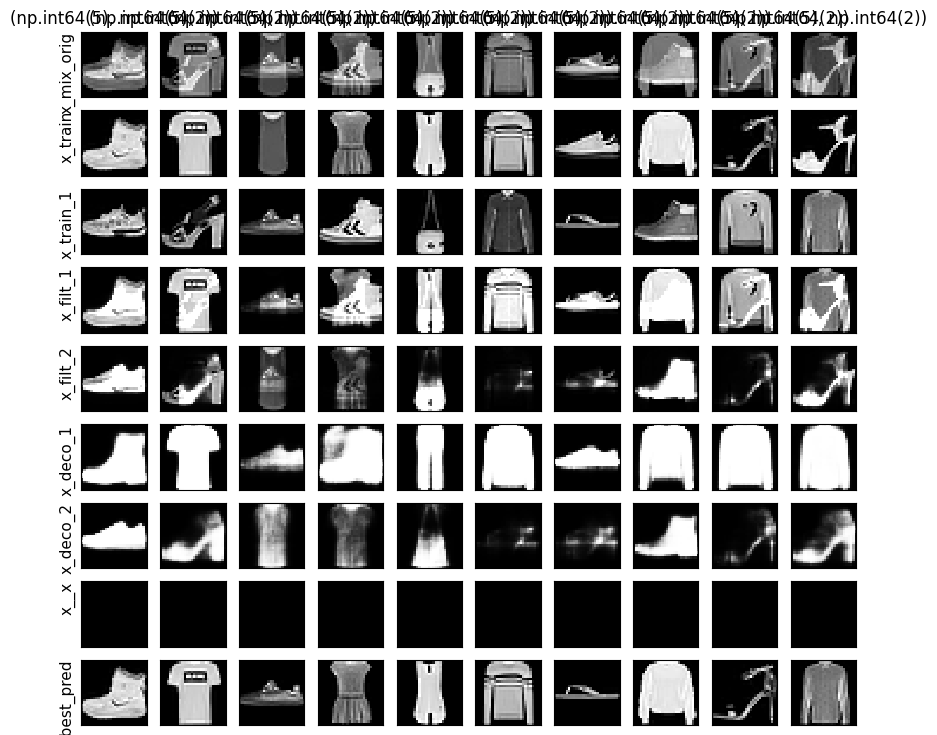

((<tf.Tensor: shape=(), dtype=float32, numpy=15.871310234069824>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.9884470701217651>),
 array([[2.12134708e-07, 4.28189537e-08, 1.36437325e-06, 6.01299746e-07,
         4.01835678e-05, 1.64548797e-03, 6.99400407e-05, 6.02451852e-03,
         2.75355618e-04, 9.91942346e-01],
        [9.96790290e-01, 2.53596369e-07, 2.36175489e-03, 1.42357210e-04,
         6.69050507e-07, 4.31662761e-10, 6.61106780e-04, 1.05186714e-07,
         4.34495923e-05, 5.93933862e-08],
        [2.22793315e-04, 2.11670791e-04, 1.31552042e-02, 4.94677154e-03,
         3.35123681e-04, 4.27236827e-03, 6.96010748e-03, 9.68914807e-01,
         2.39373403e-04, 7.41799246e-04],
        [5.17195091e-04, 3.23749031e-04, 2.81713461e-03, 5.65613527e-03,
         2.16453445e-05, 2.21680544e-04, 4.87627268e-01, 1.51585177e-01,
         5.55196428e-04, 3.50674689e-01],
        [5.17110936e-02, 6.77881002e-01, 3.03172623e-04, 2.54122108e-01,
         1.82425696e-03, 8.55930239e-07, 1

In [18]:

separar_digitos(x_train[:10], x_train_1[:10],y_train[:10], y_train_1[:10],cvae, predictor,  Iterations=3,show_graph=True)

Mejores hiperparámetros encontrados:
{'bias': 0.998187461912193, 'slope': 27.194107865807126}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


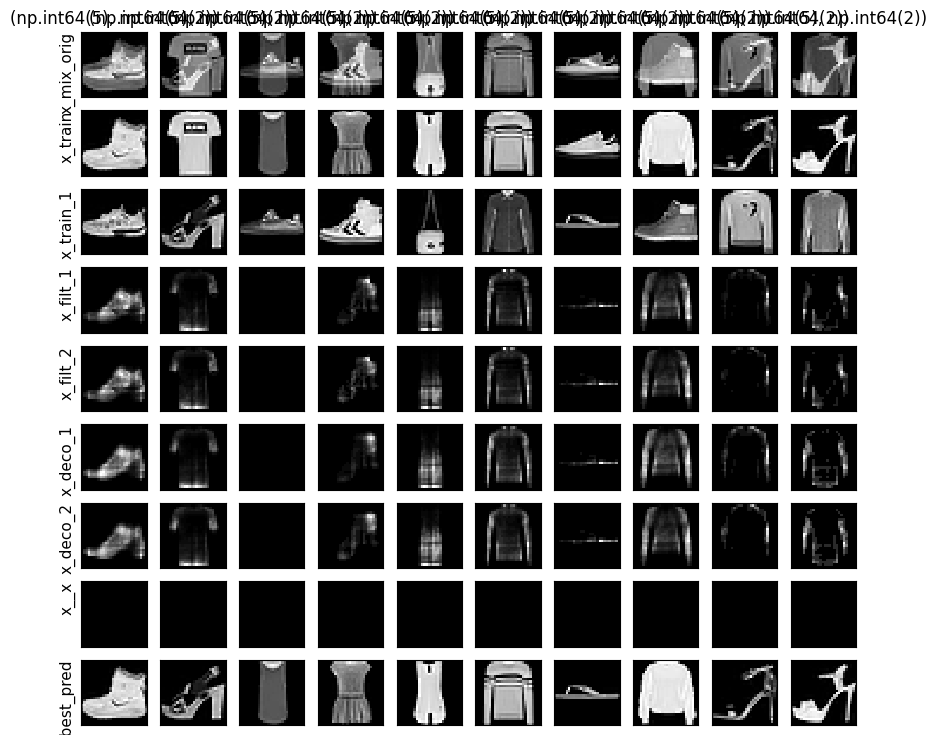

((<tf.Tensor: shape=(), dtype=float32, numpy=9.204556465148926>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8777934312820435>),
 array([[1.68568761e-07, 2.30764869e-07, 6.05464902e-06, 1.74862635e-06,
         6.47925481e-05, 4.97421890e-04, 1.11866953e-04, 2.73893654e-01,
         6.09740429e-03, 7.19326675e-01],
        [8.10888231e-01, 3.31474098e-06, 1.48121089e-01, 5.28170029e-04,
         2.63659487e-04, 8.96334740e-08, 2.76792403e-02, 1.45980186e-04,
         1.14132613e-02, 9.56910546e-04],
        [8.62805266e-03, 7.74744607e-04, 2.02883482e-02, 1.82907298e-01,
         9.40370373e-03, 3.17575614e-05, 8.23558420e-02, 6.95089877e-01,
         2.15899083e-04, 3.04481335e-04],
        [3.34804179e-03, 1.26580650e-03, 1.50548713e-03, 2.47488879e-02,
         8.20558562e-05, 3.22270498e-05, 3.68400991e-01, 3.83017398e-02,
         2.03741738e-03, 5.60277283e-01],
        [4.47610378e-01, 4.66052443e-02, 2.33368529e-03, 3.77861679e-01,
         2.68866285e-03, 3.18981478e-07, 1.

In [17]:
num_images=10
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
#study.best_value


separar_digitos(x_train[:10], x_train_1[:10],y_train[:10], y_train_1[:10],cvae, predictor, bias=study.best_params["bias"] , slope=study.best_params["slope"], Iterations=3,show_graph=True)